In [13]:
cd "C:/Users/Manip2/SCRIPTS/CodePythonAudrey/CodePythonAurelie/HayLabAnalysis/minian"

C:\Users\Manip2\SCRIPTS\CodePythonAudrey\CodePythonAurelie\HayLabAnalysis\minian


In [19]:
import os
import quantities as pq
import numpy as np
import math 
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy.interpolate import interp2d
from scipy.signal import find_peaks
from scipy.stats import zscore
import pickle
import os
from scipy.interpolate import griddata
import logging
import sys 
import shutil
from bisect import bisect_left
from ast import literal_eval
import seaborn as sns
from itertools import groupby
from ephyviewer import mkQApp, MainViewer, TraceViewer
from IPython.display import display
from ipyfilechooser import FileChooser
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [174]:
MiceList=['RedLinesOK']
MiceList=['ThreeColDotsOK']
DrugExperiment=0

In [175]:
# # Associate Ca2+ signal with spindles for each session & subsessions using crossregistration

#######################################################################################
                            # Define Experiment type #
#######################################################################################

#DrugExperiment=0 #if Baseline Experiment =1#if CGP Experiment

saveexcel=0

Method=0 # 1=AB 0=AH
AnalysisID='_ToDelete' 

suffix='_AB' if Method else '_AH'

CTX=['S1', 'PFC', 'S1PFC']
Drugs=['Baseline', 'CGP'] if DrugExperiment else ['Baseline']
Coupling=['', 'UnCoupled', 'Coupled']

#######################################################################################
                                # Load packages #
#######################################################################################

import os
import quantities as pq
import numpy as np
import math 
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy.interpolate import interp2d
from scipy.signal import find_peaks
from scipy.stats import zscore
import pickle
import os
from scipy.interpolate import griddata
import logging
import sys 
import shutil
from bisect import bisect_left
from ast import literal_eval

from itertools import groupby
from ephyviewer import mkQApp, MainViewer, TraceViewer
from IPython.display import display
from ipyfilechooser import FileChooser
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

minian_path = os.path.join(os.path.abspath('.'),'minian')
print("The folder used for minian procedures is : {}".format(minian_path))
sys.path.append(minian_path)


from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

#######################################################################################
                                # Define functions #
#######################################################################################

def take_closest2(myList, myNumber):
    value2 = 10000000
    for ind in range(len(myList)):
        value = abs(myList[ind]-myNumber)
        if value < value2:
            value2 = value
            index = myList[ind]
    return index

def is_between(myList, starttime, endtime):
    IsTrue=False
    for ind in range(len(myList)):
        if starttime <= myList[ind] <= endtime:
            IsTrue=True
    return IsTrue

def is_overlapping(starttime, endtime, starttimeList, endtimeList):
    IsTrue='False'
    for ind in starttimeList.index: #range(len(starttimeList)):
        if starttime<=starttimeList[ind] and starttimeList[ind]<=endtime: # event n°2 begins after the start n°1               
            if (endtime-starttimeList[ind])>=int(0.5*(endtime-starttime)): # overlapp > to 50% of the duration of the event n°1
                IsTrue='True'
                break                
        elif starttime<=endtimeList[ind] and endtimeList[ind]<=endtime: # event n°2 ends before the end n°1 
            if (endtimeList[ind]-starttime)>=int(0.5*(endtime-starttime)): # overlapp > to 50% of the duration of the event n°1
                IsTrue='True'
                break
    return IsTrue, ind

def find_session_folders(root_path):
    sessions = []
    sessions_path=[]
    # Iterate through items in the root_path
    for item in os.listdir(root_path):
        item_path = os.path.join(root_path, item)
        if os.path.isdir(item_path):
            # Check if the directory name contains "session"
            if "session" in item:
                sessions.append(item)
                sessions_path.append(item_path)
            else:
                # Check the subdirectories of the current directory
                for sub_item in os.listdir(item_path):
                    sub_item_path = os.path.join(item_path, sub_item)
                    if os.path.isdir(sub_item_path) and "session" in sub_item:
                        sessions.append(sub_item)
                        sessions_path.append(sub_item_path)
                        
    return sessions, sessions_path

#######################################################################################
                # Load sleep score and Ca2+ time series numpy arrays #
#######################################################################################

for mice in MiceList:

    dpath0 = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/CGP/" if DrugExperiment else "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording_ABmodified/"
    dpath=dpath0 + mice
    print(f"####################################################################################")
    print(f"################################### {mice} ####################################")
    print(f"####################################################################################")
    print(f"Path to the folder : {dpath}")
    folder_base = Path(dpath)

    mfile = open(folder_base / f'mappingsAB_ALL.pkl', 'rb')
    mapping = pickle.load(mfile)
    print('mappingsAB_ALL.pkl opened')

    subsessions = []
    dict_Calcium = {}
    dict_Spike = {}
    dict_SWRprop = {}
    dict_Spindleprop = {}
    dict_Stamps = {}
    dict_StampsMiniscope = {}
    dict_TodropFile = {}
    dict_Path={}

    sessions, sessions_path = find_session_folders(folder_base)
    nb_sessions=len(sessions)

    for sess,session in enumerate(sessions):  
        session_path=Path(sessions_path[sess])
        folder_mini = session_path / f'V4_Miniscope'
        nb_subsessions = sum(1 for p in folder_mini.iterdir() if p.is_dir() and p.name.startswith("session"))
        SWRproperties = session_path / f'OpenEphys/SWRproperties_8sd_AB.xlsx' if Method else session_path / f'OpenEphys/SWRproperties.csv'
        Spindleproperties = session_path / f'OpenEphys/Spindlesproperties_S1&PFC_7sd_AB.xlsx' if Method else session_path / f'OpenEphys/Spindleproperties_S1&PFC.csv'
        StampsFile = session_path / f'SynchroFile.xlsx'
        StampsMiniscopeFile = folder_mini / f'timeStamps.csv'
        if nb_subsessions!=0:
            for x in range(1, nb_subsessions+1):            
                subsession= session + str(x)
                subsessions.append(subsession)    
                minian_ds = open_minian(folder_mini / subsession / f'minian')      # OR minianAB
                SWRlist= pd.read_excel(SWRproperties) if Method else pd.read_csv(SWRproperties)
                SWRlist['toKeep'] = SWRlist['toKeep'].astype(str)  if DrugExperiment else 'True'
                dict_SWRprop[subsession]  =SWRlist[SWRlist['toKeep'].isin(['VRAI', 'True'])]
                Spdllist = pd.read_excel(Spindleproperties) if Method else pd.read_csv(Spindleproperties)
                Spdllist['toKeep'] = Spdllist['toKeep'].astype(str)
                dict_Spindleprop[subsession]  = Spdllist[Spdllist['toKeep'].isin(['VRAI', 'True'])]
                dict_Path[subsession] = session_path
                dict_Calcium[subsession] = minian_ds['C'] # calcium traces 
                dict_Spike[subsession] = minian_ds['S'] # estimated spikes
                dict_Stamps[subsession]  = pd.read_excel(StampsFile)
                dict_StampsMiniscope[subsession]  = pd.read_csv(StampsMiniscopeFile)
                try:
                    TodropFile = folder_mini / subsession / f'minian/TodropFileAB.json'
                    with open(TodropFile, 'r') as f:
                        unit_to_drop = json.load(f)
                        dict_TodropFile[subsession]  = unit_to_drop
                except:
                    TodropFile = folder_mini / subsession / f'minian/TodropFile.json'
                    with open(TodropFile, 'r') as f:
                        unit_to_drop = json.load(f)
                        dict_TodropFile[subsession]  = unit_to_drop
        else:
            minian_ds = open_minian(folder_mini / f'minian')            # OR minianAB
            dict_Path[session] = session_path
            dict_Calcium[session] = minian_ds['C'] # calcium traces 
            dict_Spike[session] = minian_ds['S'] # estimated spikes
            SWRlist= pd.read_excel(SWRproperties) if Method else pd.read_csv(SWRproperties)
            SWRlist['toKeep'] = SWRlist['toKeep'].astype(str) if DrugExperiment else 'True'
            dict_SWRprop[session]  =SWRlist[SWRlist['toKeep'].isin(['VRAI', 'True'])]
            Spdllist = pd.read_excel(Spindleproperties) if Method else pd.read_csv(Spindleproperties)
            Spdllist['toKeep'] = Spdllist['toKeep'].astype(str) 
            dict_Spindleprop[session]  = Spdllist[Spdllist['toKeep'].isin(['VRAI', 'True'])]
            dict_Stamps[session]  = pd.read_excel(StampsFile)
            dict_StampsMiniscope[session]  = pd.read_csv(StampsMiniscopeFile)
            try:
                TodropFile = folder_mini / f'minian/TodropFileAB.json'
                with open(TodropFile, 'r') as f:
                    unit_to_drop = json.load(f)
                    dict_TodropFile[session]  = unit_to_drop
            except:
                TodropFile = folder_mini / f'minian/TodropFile.json'
                with open(TodropFile, 'r') as f:
                    unit_to_drop = json.load(f)
                    dict_TodropFile[session]  = unit_to_drop

    #######################################################################################
                            # Cross registration results #
    #######################################################################################

    B = mapping['session']
    if mice == 'Purple' and DrugExperiment==0:
        index = B.columns
        B.columns = index.str.replace('part', 'session2')

    #######################################################################################
      # Distribute Ca2+ intensity & spikes to oscillations for each sessions/subsessions #
    #######################################################################################

    data = {}        
    before = 500 # Max distance in ms between a SWR and a spindle to be considered as Precoupled
    after = 1000 # Max distance in ms between a spindle and a SWR to be considered as Postcoupled
    durationSpdl = 5 # number of sec before and after the Spdl onset taken into acount
    durationSWR = 1 # number of sec before and after the SWR onset taken into acount
    counter=0
    counter2=0

    norm_freq=20 # final miniscope frequency used for all recordings

    Spindles_GlobalResults= pd.DataFrame(data, columns=['Mice', 'Session','Session_Time','Unique_Unit','UnitNumber','UnitValue','Drug', 'SpdlStatut','SpdlStartLocation', 'GlobalSpindle', 'SpdlNumber','SpdlDuration','SWR_inside_Spdl','CalciumActivityPreference', 'CalciumActivityBefore','CalciumActivityDuring','CalciumActivityAfter','AUC_calciumBefore','AUC_calciumDuring','AUC_calciumAfter','SpikeActivityPreference','SpikeActivityBefore','SpikeActivityDuring','SpikeActivityAfter'])
    SWR_GlobalResults= pd.DataFrame(data, columns=['Mice', 'Session','Session_Time','Unique_Unit','UnitNumber','UnitValue','Drug','SWRStatut','SWRNumber','SWRDuration','SWR_inside_Spdl','CalciumActivityPreference', 'CalciumActivityBefore','CalciumActivityDuring','CalciumActivityAfter','AUC_calciumBefore','AUC_calciumDuring','AUC_calciumAfter','SpikeActivityPreference','SpikeActivityBefore','SpikeActivityDuring','SpikeActivityAfter'])
        
    for drug in Drugs: 
        for coup in Coupling:
            for ctx in CTX:            
                locals()[f'dict_All_ActivityCa_{coup}SPDL{ctx}_{drug}']={}
                locals()[f'dict_All_ActivitySp_{coup}SPDL{ctx}_{drug}']={}
            locals()[f'dict_All_ActivityCa_{coup}SWR_{drug}']={}
            locals()[f'dict_All_ActivitySp_{coup}SWR_{drug}']={}

    previousEndTime=0
    InitialStartTime=0

    for session in list(dict_Stamps.keys()):    
        cCoupled=0
        cUnCoupled=0
        cGlobal=0
        cLocalS1=0
        cLocalPFC=0

        cCoupledSWR=0
        cUnCoupledSWR=0      
        
        drug=os.path.basename(os.path.dirname(dict_Path[session])) if DrugExperiment else 'Baseline'

        # Start time & freq miniscope

        StartTime = list(dict_Stamps[session][0])[0] # in seconds
        minian_freq=list(dict_Stamps[session][0])[2] # in Hz

        if minian_freq>=20: # should only remove 1 session                

            C=dict_Calcium[session]
            Cupd = C.loc[:, :]
            rec_dur = Cupd.shape[1]
            S=dict_Spike[session] 
            Supd = S.loc[:, :] 

            # Adjust the StartTime if subsessions

            if InitialStartTime==0:
                InitialStartTime=StartTime    
                StartTimeMiniscope=0 # start time of miniscope rec of that subsesssions relative to the start of the mniscope recording
            else:
                if StartTime == InitialStartTime:
                    StartTime = previousEndTime + 1/minian_freq #  +1 frame in seconds
                    StartTimeMiniscope= StartTime-InitialStartTime
                else:  
                    InitialStartTime=StartTime
                    StartTimeMiniscope=0   

            # Deal with dropped frames (failure to acquire miniscope images)

            list_droppedframes = literal_eval(dict_Stamps[session][0][3])    

            numbdropfr= 0   
            upd_rec_dur=rec_dur
            droppedframes_inrec=[]
            for item in list_droppedframes: 
                if item < (int(StartTimeMiniscope*minian_freq) + upd_rec_dur) and item > int(StartTimeMiniscope*minian_freq):
                    droppedframes_inrec.append(item-int(StartTimeMiniscope*minian_freq))
                    upd_rec_dur+=1 #add the dropped frame to the recording length
                    numbdropfr+=1                        

            EndTime = StartTime + (upd_rec_dur/minian_freq) # in seconds
            previousEndTime=EndTime     

            print(session, ': starts at', round(StartTime,1), 's & ends at', round(EndTime,1), 's (', round(upd_rec_dur/minian_freq,1), 's duration, ', numbdropfr, 'dropped frames, minian frequency =', minian_freq, 'Hz, drug = ', drug, ')...') 
            
            # Remove bad units from recordings

            AA = C['unit_id']
            copyAA = list(AA.copy())
            unit_to_drop=dict_TodropFile[session]    
            for u in unit_to_drop: # ugly way to do it, need to be improved to only use unit_to_drop
                copyAA.remove(u)
            unit_to_keep = copyAA
            Cupd = Cupd.loc[unit_to_keep,:]
            Carray = Cupd.values.T
            Supd = Supd.loc[unit_to_keep,:]
            Sarray = Supd.values.T
            nb_unit = Cupd.shape[0]
            units = range(nb_unit)
                            
            C_upd_unit_id = Cupd['unit_id'].values
            kept_uniq_unit_List=[]
            for unit in units:
                indexMapp = np.where(B[session] == C_upd_unit_id[unit])[0]
                kept_uniq_unit_List.append(str(indexMapp))

            sentence1= f"... kept values = {kept_uniq_unit_List}"
            print(sentence1)     
            
            if nb_unit==0:
                continue  # next iteration
            
            # Zscore traces
            #Carray=zscore(Carray, axis=0)
            #Sarray=zscore(Sarray, axis=0)

            # Replace dropped frame in calcium and spike traces with the previous value

            for droppedframe in droppedframes_inrec: 
                row_to_repeat = Carray[droppedframe]  
                Carray = np.vstack((Carray[:droppedframe], row_to_repeat, Carray[droppedframe:]))
                row_to_repeat = Sarray[droppedframe]  
                Sarray = np.vstack((Sarray[:droppedframe], row_to_repeat, Sarray[droppedframe:]))

            # Align Oscillations to miniscope start 

            SpipropO=dict_Spindleprop[session]
            SpipropM=SpipropO.copy()
            SWRpropO=dict_SWRprop[session]
            SWRpropM=SWRpropO.copy()
            SpipropM[["peak time", "start time", "end time"]] = SpipropM[["peak time", "start time", "end time"]]-(StartTime*1000)
            SWRpropM[["peak time", "start time", "end time"]] = SWRpropM[["peak time", "start time", "end time"]]-(StartTime*1000)        

            timeSpdl = range(int(durationSpdl*2*minian_freq))
            HalfSpdl = int(durationSpdl*minian_freq)
            
            timeSWR = range(int(durationSWR*2*minian_freq))
            HalfSWR = int(durationSWR*minian_freq)

            TimeStamps_miniscope=list(dict_StampsMiniscope[session]["Time Stamp (ms)"]) # + (StartTime*1000))

            SpipropTrunc = SpipropM[SpipropM["start time"]>0]
            SpipropTrunc = SpipropTrunc[SpipropTrunc["start time"]< (EndTime-StartTime)*1000]
            SWRpropTrunc = SWRpropM[SWRpropM["start time"]>0]
            SWRpropTrunc = SWRpropTrunc[SWRpropTrunc["start time"] < (EndTime-StartTime)*1000]

            nb_spindle = SpipropTrunc.shape[0]
            nb_swr = SWRpropTrunc.shape[0]

            for unit in units: # for each kept units (cause Cseries/Sseries only have kept units)

                Carray_unit =Carray[:,unit]
                Sarray_unit =Sarray[:,unit]
                #peaks, _ = find_peaks(Sarray_unit)#, height=np.std(SpTrace))
                #Sarray_unit=np.zeros(len(Sarray_unit))
                #Sarray_unit[peaks]=1

                #######################################################################################
                                                    # for SPDLs #
                #######################################################################################
                for coup in Coupling:
                    for ctx in CTX:            
                        locals()[f'ActivityCa_{coup}Spin{ctx}']=[] #For each unit 
                        locals()[f'ActivitySp_{coup}Spin{ctx}']=[] #For each unit  

                for Pspin in SpipropTrunc.index: 
                    
                    # Get the calcium and spike trace associated with the spdl
     
                    startSpi=SpipropTrunc.loc[Pspin, "start time"]                
                    endSpi=SpipropTrunc.loc[Pspin, "end time"]    
                    ctxSpi=SpipropTrunc.loc[Pspin, "CTX"]                
                    diffSpi=SpipropTrunc.loc[Pspin, "LocalGlobal"]                
                    StartLocSpi=SpipropTrunc.loc[Pspin, "StartingLoc"]   
                                 

                    TooEarlySpdl=startSpi/1000<durationSpdl # too close to the begining of the recording
                    TooLateSpdl=startSpi/1000+durationSpdl>round((upd_rec_dur)/minian_freq,1) # too close to the end of the recording
                    
                    if TooEarlySpdl or TooLateSpdl:
                        print("/!\ Spindle too close to the begining/end of the recording,", session, ", Spdl n°", Pspin, ", Start Spdl =", round(startSpi/1000,1), "s") if unit==0 else None            
                    else:

                        if ctxSpi=='S1':
                            cLocalS1+=1 if unit==0 else 0
                        elif ctxSpi=='PFC': 
                            cLocalPFC+=1 if unit==0 else 0
                        elif ctxSpi=='S1PFC': 
                            cGlobal+=1 if unit==0 else 0    

                        Frame_Spindle_start = int(startSpi/1000*minian_freq)                            
                        CaTrace = list(Carray_unit[Frame_Spindle_start-HalfSpdl:Frame_Spindle_start+HalfSpdl])
                        SpTrace = list(Sarray_unit[Frame_Spindle_start-HalfSpdl:Frame_Spindle_start+HalfSpdl]) 
                        
                        ActivityCa_Spin=locals()[f'ActivityCa_Spin{ctxSpi}']
                        ActivitySp_Spin=locals()[f'ActivitySp_Spin{ctxSpi}']

                        ActivityCa_Spin.append(CaTrace)
                        ActivitySp_Spin.append(SpTrace)               

                        # Define if that spindle is coupled with a SWR or not

                        Spdl_statut=[]
                        startSWRList = list(pd.Series(SWRpropTrunc["start time"]))
                        if len(startSWRList)>0:
                            startClosest_SWR = take_closest2(startSWRList, startSpi)
                            distance = abs(startClosest_SWR - startSpi)
                            IsTrue=is_between(startSWRList,startSpi, endSpi)
                            if (distance < before) or IsTrue:
                                Spdl_statut = 'Coupled'
                                cCoupled+=1 if unit==0 else 0                              
                            else:
                                Spdl_statut= 'UnCoupled'
                                cUnCoupled+=1 if unit==0 else 0
                        else:
                            Spdl_statut= 'UnCoupled'
                            cUnCoupled+=1 if unit==0 else 0

                        ActivityCa_SpinCp=locals()[f'ActivityCa_{Spdl_statut}Spin{ctxSpi}']
                        ActivitySp_SpinCp=locals()[f'ActivitySp_{Spdl_statut}Spin{ctxSpi}']
                        ActivityCa_SpinCp.append(CaTrace)
                        ActivitySp_SpinCp.append(SpTrace)

                        # Fill the big summary table Spindles_GlobalResults

                        Spindles_GlobalResults.loc[counter, 'Mice'] = mice
                        Spindles_GlobalResults.loc[counter, 'Session'] = session
                        Spindles_GlobalResults.loc[counter, 'Session_Time'] = None 

                        indexMapp = np.where(B[session] == C_upd_unit_id[unit])[0]
                        Spindles_GlobalResults.loc[counter, 'Unique_Unit'] = indexMapp 
                        Spindles_GlobalResults.loc[counter, 'UnitNumber'] = unit 
                        Spindles_GlobalResults.loc[counter, 'UnitValue'] = C_upd_unit_id[unit] 
                        
                        Spindles_GlobalResults.loc[counter, 'Drug'] =  os.path.basename(os.path.dirname(dict_Path[session])) if DrugExperiment else 'Baseline'

                        Spindles_GlobalResults.loc[counter, 'SpdlStatut'] = Spdl_statut
                        Spindles_GlobalResults.loc[counter, 'SpdlStartLocation'] = StartLocSpi
                        Spindles_GlobalResults.loc[counter, 'GlobalSpindle'] = diffSpi
                        Spindles_GlobalResults.loc[counter, 'SpdlNumber'] = Pspin
                        Spindles_GlobalResults.loc[counter, 'SpdlDuration'] = endSpi- startSpi                        
                        Spindles_GlobalResults.loc[counter, 'SWR_inside_Spdl'] = IsTrue
                        
                        # Activity before/ during/after oscillation

                        durOsc=int((endSpi- startSpi)/1000*minian_freq)
                        TooEarlySpdl=startSpi/1000<durOsc/minian_freq # too close to the begining of the recording
                        TooLateSpdl=startSpi/1000+(durOsc/minian_freq*2)>round((upd_rec_dur)/minian_freq,1) # too close to the end of the recording
                        if TooEarlySpdl or TooLateSpdl:
                            print("/!\ Spindle too close to the begining/end of the recording,", session, ", Spdl n°", Pspin, ", Start Spdl =", round(startSpi/1000,1), "s, recdur=", round((upd_rec_dur)/minian_freq,1)) if unit==0 else None            
                        else:                                
                            CaTrace = list(Carray_unit[Frame_Spindle_start-durOsc:Frame_Spindle_start+durOsc*2])
                            SpTrace = list(Sarray_unit[Frame_Spindle_start-durOsc:Frame_Spindle_start+durOsc*2]) 
                        
                            ActBefore=np.mean(CaTrace[:durOsc],0)
                            ActDuring=np.mean(CaTrace[durOsc:durOsc*2],0)
                            ActAfter=np.mean(CaTrace[durOsc*2:durOsc*3],0)
                                    
                            if ActBefore > ActDuring and ActBefore > ActAfter:
                                pref='Before'
                            elif ActAfter > ActDuring and ActAfter > ActBefore:
                                pref='After' 
                            elif ActDuring > ActAfter and ActDuring > ActBefore:
                                pref='During' 
                            else:
                                pref='None'
                            Spindles_GlobalResults.loc[counter, 'CalciumActivityPreference'] = pref
                            Spindles_GlobalResults.loc[counter, 'CalciumActivityBefore'] = ActBefore
                            Spindles_GlobalResults.loc[counter, 'CalciumActivityDuring'] = ActDuring
                            Spindles_GlobalResults.loc[counter, 'CalciumActivityAfter'] = ActAfter
                            Spindles_GlobalResults.loc[counter, 'AUC_calciumBefore'] = np.trapz(CaTrace[:durOsc],np.arange(0,len(CaTrace[:durOsc]),1))
                            Spindles_GlobalResults.loc[counter, 'AUC_calciumDuring'] = np.trapz(CaTrace[durOsc:durOsc*2],np.arange(0,len(CaTrace[durOsc:durOsc*2]),1))          
                            Spindles_GlobalResults.loc[counter, 'AUC_calciumAfter'] = np.trapz(CaTrace[durOsc*2:durOsc*3],np.arange(0,len(CaTrace[durOsc*2:durOsc*3]),1))          

                            ActBefore=np.mean(SpTrace[:durOsc],0)
                            ActDuring=np.mean(SpTrace[durOsc:durOsc*2],0)
                            ActAfter=np.mean(SpTrace[durOsc*2:durOsc*3],0)

                            if ActBefore > ActDuring and ActBefore > ActAfter:
                                pref='Before'
                            elif ActAfter > ActDuring and ActAfter > ActBefore:
                                pref='After' 
                            elif ActDuring > ActAfter and ActDuring > ActBefore:
                                pref='During' 
                            else:
                                pref='None'
                            Spindles_GlobalResults.loc[counter, 'SpikeActivityPreference'] = pref
                            Spindles_GlobalResults.loc[counter, 'SpikeActivityBefore'] = np.mean(SpTrace[:durOsc],0)
                            Spindles_GlobalResults.loc[counter, 'SpikeActivityDuring'] = np.mean(SpTrace[durOsc:durOsc*2],0)
                            Spindles_GlobalResults.loc[counter, 'SpikeActivityAfter'] = np.mean(SpTrace[durOsc*2:durOsc*3],0)                         
                        counter+=1     

                ## Peristimulus Time Histogram 
                for ctx in CTX: 
                    for coup in Coupling: 
                        # All Ca traces for each spindles per Unique unit (according to cross-registration)
                        ActivityCa = locals()[f'ActivityCa_{coup}Spin{ctx}']
                        dict_All_ActivityCa = locals()[f'dict_All_ActivityCa_{coup}SPDL{ctx}_{drug}']
                        ActivitySp = locals()[f'ActivitySp_{coup}Spin{ctx}']
                        dict_All_ActivitySp = locals()[f'dict_All_ActivitySp_{coup}SPDL{ctx}_{drug}']
                        if len(indexMapp) > 0: #not empty --> cause some units are not in the cross registration..! Need to know why    
                            if len(ActivityCa)>0 :                                
                                if np.shape(np.array(ActivityCa))[1] == int(norm_freq*durationSpdl*2):  #normalize traces to the same frequency rate         
                                    ActivityCa= np.reshape(np.array(ActivityCa), (-1, len(np.array(ActivityCa)))) if np.ndim(ActivityCa) == 1 else np.array(ActivityCa)    
                                    ActivitySp= np.reshape(np.array(ActivitySp), (-1, len(np.array(ActivitySp)))) if np.ndim(ActivitySp) == 1 else np.array(ActivitySp)    
                                    key=mice + str(indexMapp).replace('[','').replace(']','')
                                    dict_All_ActivityCa[key] = np.append(dict_All_ActivityCa[key], np.array(ActivityCa), axis=0) if key in dict_All_ActivityCa else np.array(ActivityCa)
                                    dict_All_ActivitySp[key] = np.append(dict_All_ActivitySp[key], np.array(ActivitySp), axis=0) if key in dict_All_ActivitySp else np.array(ActivitySp)
                                else:
                                    dataO = np.array(ActivityCa)
                                    data= np.repeat(dataO, 2, axis=0) if dataO.shape[0] == 1 else dataO
                                    x_mesh, y_mesh = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
                                    x_new_mesh, y_new_mesh = np.meshgrid(np.linspace(0, data.shape[1] - 1, int(norm_freq*durationSpdl*2)), np.linspace(0, data.shape[0] - 1, np.shape(data)[0]))
                                    resampled_dataO = griddata((x_mesh.flatten(), y_mesh.flatten()), data.flatten(), (x_new_mesh, y_new_mesh), method='linear')
                                    resampled_data= resampled_dataO[0,:] if dataO.shape[0] == 1 else resampled_dataO
                                    resampled_data= np.reshape(resampled_data, (-1, len(resampled_data))) if np.ndim(resampled_data) == 1 else resampled_data
                                    key=mice + str(indexMapp).replace('[','').replace(']','')
                                    dict_All_ActivityCa[key] = np.append(dict_All_ActivityCa[key], np.array(resampled_data), axis=0) if key in dict_All_ActivityCa else np.array(resampled_data)

                                    dataO = np.array(ActivitySp)
                                    data= np.repeat(dataO, 2, axis=0) if dataO.shape[0] == 1 else dataO
                                    x_mesh, y_mesh = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
                                    x_new_mesh, y_new_mesh = np.meshgrid(np.linspace(0, data.shape[1] - 1, int(norm_freq*durationSpdl*2)), np.linspace(0, data.shape[0] - 1, np.shape(data)[0]))
                                    resampled_dataO = griddata((x_mesh.flatten(), y_mesh.flatten()), data.flatten(), (x_new_mesh, y_new_mesh), method='nearest')
                                    resampled_data= resampled_dataO[0,:] if dataO.shape[0] == 1 else resampled_dataO
                                    resampled_data= np.reshape(resampled_data, (-1, len(resampled_data))) if np.ndim(resampled_data) == 1 else resampled_data
                                    key=mice + str(indexMapp).replace('[','').replace(']','')
                                    dict_All_ActivitySp[key] = np.append(dict_All_ActivitySp[key], np.array(resampled_data), axis=0) if key in dict_All_ActivitySp else np.array(resampled_data)
            sentence2=f"... {nb_spindle} spindles ({cCoupled} Coupled & {cUnCoupled} Uncoupled Spdl // {cGlobal} Global, {cLocalS1} LocalS1 & {cLocalPFC} LocalPFC) and {nb_swr} SWR detected ({cCoupledSWR} Coupled & {cUnCoupledSWR} Uncoupled SWR)"
            print(sentence2) 
        else:
            print(f'/!\ {session} not taken into account cause minian frequency = {minian_freq}')
                


The folder used for minian procedures is : C:\Users\Manip2\SCRIPTS\CodePythonAudrey\CodePythonAurelie\HayLabAnalysis\minian\minian
####################################################################################
################################### ThreeColDotsOK ####################################
####################################################################################
Path to the folder : //10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording_ABmodified/ThreeColDotsOK
mappingsAB_ALL.pkl opened
session11 : starts at 3.1 s & ends at 803.1 s ( 800.0 s duration,  1 dropped frames, minian frequency = 30 Hz, drug =  Baseline )...
... kept values = ['[567]', '[254]', '[127]', '[272]', '[113]', '[46]', '[78]', '[571]', '[17]', '[12]', '[575]', '[122]', '[132]', '[577]', '[579]', '[4]', '[583]', '[585]', '[586]', '[147]', '[13]', '[16]', '[177]', '[131]', '[133]', '[588]', '[589]', '[5]', '[51]', '[206]', '[593]', '[566]', '[569]', '[7]'

In [115]:
dff[dff['%During']>20]

SpikeActivityPreference,After,Before,During,NoPref,Total,%Before,%During,%After,%Response
Unit_ID,,,,,,,,,
Purple1047,0,3,3,0,6,50.00,50.00,0.00,100.00
Purple130,2,1,3,8,14,7.14,21.43,14.29,42.86
Purple52,2,3,7,16,28,10.71,25.00,7.14,42.86
ThreeColDotsOK112,4,1,9,9,23,4.35,39.13,17.39,60.87
ThreeColDotsOK128,5,3,7,19,34,8.82,20.59,14.71,44.12
ThreeColDotsOK1341,3,0,3,4,10,0.00,30.00,30.00,60.00
ThreeColDotsOK149,1,2,4,6,13,15.38,30.77,7.69,53.85
ThreeColDotsOK204,6,4,8,16,34,11.76,23.53,17.65,52.94
ThreeColDotsOK296,3,5,6,9,23,21.74,26.09,13.04,60.87


In [166]:
nr='RedLinesOK4'
nr='ThreeColDotsOK91'

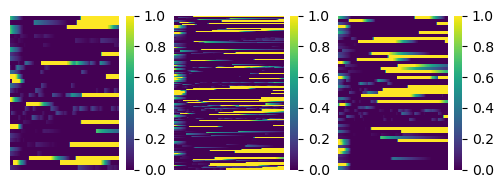

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def process_and_plot(data, ax, vmin=0, vmax=1):
    baseline_columns = data[:, :data.shape[1] // 4]
    mean_baseline = baseline_columns.mean(axis=1)[:, np.newaxis]
    data2 = data - mean_baseline
    sns.heatmap(data2, ax=ax, cmap='viridis', xticklabels=False, yticklabels=False, vmin=vmin, vmax=vmax)
plt.close()

fig, axes = plt.subplots(1, 3, figsize=(6, 2))

# Check if subplots are correctly created
process_and_plot(dict_All_ActivityCa_SPDLS1PFC_Baseline[nr], axes[0])
process_and_plot(dict_All_ActivityCa_SPDLS1_Baseline[nr], axes[1])
process_and_plot(dict_All_ActivityCa_SPDLPFC_Baseline[nr], axes[2])

plt.savefig(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_{nr}_heatmap_Spdl_Catraces.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()


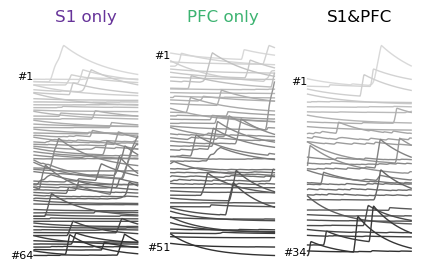

In [168]:
plt.close()
fig, axes = plt.subplots(1, 3, figsize=(5, 3))  # Increased figure size for better readability

#cmap = sns.light_palette("#008B8B", as_cmap=True)
cmap = sns.light_palette("black", as_cmap=True)

def plot_lines(data, ax, title, xlabel=None, title_color='black', cmap=cmap):
    baseline_columns = data[:, :data.shape[1] // 4]
    mean_baseline = baseline_columns.mean(axis=1)[:, np.newaxis]
    data2 = data - mean_baseline
    num_lines = data2.shape[0]
    colors = cmap(np.linspace(0.1, .8, num_lines))
    ax.text(-1,0, f'#1', color='black', ha='right', va='center', fontsize=8) 
    # Plot each line with a label
    for i in range(num_lines):
        line_data = data2[i] - i * 1.5
        ax.plot(0, min(line_data), line_data, color=colors[i], linewidth=1)
    ax.text(-1, min(line_data), f'#{i+1}', color='black', ha='right', va='center', fontsize=8) 
    ax.set_title(title, fontsize=12, color=title_color, pad=10)  # Added padding for the title
    if xlabel:
        ax.set_xlabel(xlabel, labelpad=2, fontsize=10)    
    ax.axis('off')  # Hide axis lines and labels

data = dict_All_ActivityCa_SPDLS1_Baseline[nr][::2] *1  # [::2] Taking every other row
plot_lines(data, axes[0], 'S1 only', title_color='rebeccapurple')
data = dict_All_ActivityCa_SPDLPFC_Baseline[nr]*1
plot_lines(data, axes[1], 'PFC only', title_color='mediumseagreen')
data = dict_All_ActivityCa_SPDLS1PFC_Baseline[nr]*1
plot_lines(data, axes[2], 'S1&PFC')

output_path = f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_line_{nr}_Spdl_CatracesLag.svg'
plt.savefig(output_path, format='svg', bbox_inches='tight', pad_inches=0, transparent=True)

# Show the plot
plt.show()


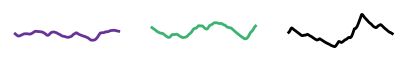

In [173]:
plt.close()
fig, axes = plt.subplots(1, 3, figsize=(5, .5))  # Increased figure size for better readability

cmap = sns.light_palette("#008B8B", as_cmap=True)
#cmap = sns.light_palette("black", as_cmap=True)

def plot_lines(data, ax,title_color='black', cmap=cmap):
    baseline_columns = data[:, :data.shape[1] // 4]
    mean_baseline = baseline_columns.mean(axis=1)[:, np.newaxis]
    data2 = data - mean_baseline
    ax.plot(np.nanmean(data2, axis=0), color=title_color, linewidth=2)
    ax.set_ylim(-.6, 1)    
    ax.axis('off')  # Hide axis lines and labels

data = dict_All_ActivityCa_SPDLS1_Baseline[nr]*1  # [::2] Taking every other row
plot_lines(data, axes[0],  title_color='rebeccapurple')
data = dict_All_ActivityCa_SPDLPFC_Baseline[nr]*1
plot_lines(data, axes[1], title_color='mediumseagreen')
data = dict_All_ActivityCa_SPDLS1PFC_Baseline[nr]*1
plot_lines(data, axes[2])

output_path = f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_AVG_{nr}_Spdl_CatracesLag.svg'
plt.savefig(output_path, format='svg', bbox_inches='tight', pad_inches=0, transparent=True)

# Show the plot
plt.show()


In [100]:
path="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/AB_GlobalAnalysis/AVG_Osc_2024-08-29_16_18_05_AH_5sec/L1_Spdl_Global.xlsx"
path="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/AB_GlobalAnalysis/AVG_Osc_2024-08-29_16_18_05_AH_5sec/L2&3_Spdl_Global.xlsx"
dfa=pd.read_excel(path)

In [101]:
path="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/AB_GlobalAnalysis/AVG_VigSt_2024-08-22_10_49_35_AB_noN2/Baseline/All/L1_VigSt_nAUC.xlsx"
path="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/AB_GlobalAnalysis/AVG_VigSt_2024-08-22_10_49_35_AB_noN2/Baseline/All/L2&3_VigSt_nAUC.xlsx"
dfi=pd.read_excel(path)

In [102]:
dfii = dfi.pivot_table(index='Unit_ID', values='NREM', fill_value=0)
dfii2 = dfi.pivot_table(index='Unit_ID', values='RatioNREM_REM', fill_value=0)
dfAll=pd.concat([dfii,dfii2], axis=1, ignore_index=False)


dfd = dfa[dfa['GlobalSpindle'] == 'Local'] 
dfd = dfd[dfd['SpdlStartLocation'] == 'S1'] 
dfd['NormAUCBeforeS1']=dfd['AUC_calciumBefore']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCBeforeS1', aggfunc='mean', fill_value=0)
dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)

dfd['NormAUCDuringS1']=dfd['AUC_calciumDuring']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCDuringS1', aggfunc='mean', fill_value=0)
dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)



dfd = dfa[dfa['GlobalSpindle'] == 'Local'] 
dfd = dfd[dfd['SpdlStartLocation'] == 'PFC'] 
dfd['NormAUCBeforePFC']=dfd['AUC_calciumBefore']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCBeforePFC', aggfunc='mean', fill_value=0)
dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)

dfd['NormAUCDuringPFC']=dfd['AUC_calciumDuring']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCDuringPFC', aggfunc='mean', fill_value=0)

dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)

dfd = dfa[dfa['Drug'] == 'Baseline'] 
dfd = dfd[dfd['GlobalSpindle'] == 'Global'] 
dfd['NormAUCBeforeGBL']=dfd['AUC_calciumBefore']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCBeforeGBL', aggfunc='mean', fill_value=0)
dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)

dfd['NormAUCDuringGBL']=dfd['AUC_calciumDuring']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCDuringGBL', aggfunc='mean', fill_value=0)

dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)

dfAll['S1diff']=dfAll['NormAUCDuringS1']-dfAll['NormAUCBeforeS1']
dfAll['PFCdiff']=dfAll['NormAUCDuringPFC']-dfAll['NormAUCBeforePFC']
dfAll['GBLdiff']=dfAll['NormAUCDuringGBL']-dfAll['NormAUCBeforeGBL']

dfAll = dfAll.dropna(subset=['RatioNREM_REM'])

df_cleaned=dfAll.copy()
df_cleaned = df_cleaned.dropna(subset=['S1diff'])
dfAllnrem=df_cleaned[df_cleaned['RatioNREM_REM']>0.5]
dfAllrem=df_cleaned[df_cleaned['RatioNREM_REM']<-0.5]
dfAllns=df_cleaned[df_cleaned['RatioNREM_REM']<=0.5]
dfAllns=dfAllns[dfAllns['RatioNREM_REM']>=-0.5]

print('S1')
print(sum(dfAllnrem['S1diff']>0)/len(df_cleaned)*100)
print(sum(dfAllns['S1diff']>0)/len(df_cleaned)*100)
print(sum(dfAllrem['S1diff']>0)/len(df_cleaned)*100)

df_cleaned=dfAll.copy()
df_cleaned = dfAll.dropna(subset=['PFCdiff'])
dfAllnrem=df_cleaned[df_cleaned['RatioNREM_REM']>0.5]
dfAllrem=df_cleaned[df_cleaned['RatioNREM_REM']<-0.5]
dfAllns=df_cleaned[df_cleaned['RatioNREM_REM']<=0.5]
dfAllns=dfAllns[dfAllns['RatioNREM_REM']>=-0.5]

print('PFC')
print(sum(dfAllnrem['PFCdiff']>0)/len(df_cleaned)*100)
print(sum(dfAllns['PFCdiff']>0)/len(df_cleaned)*100)
print(sum(dfAllrem['PFCdiff']>0)/len(df_cleaned)*100)

df_cleaned=dfAll.copy()
df_cleaned = dfAll.dropna(subset=['GBLdiff'])
dfAllnrem=df_cleaned[df_cleaned['RatioNREM_REM']>0.5]
dfAllrem=df_cleaned[df_cleaned['RatioNREM_REM']<-0.5]
dfAllns=df_cleaned[df_cleaned['RatioNREM_REM']<=0.5]
dfAllns=dfAllns[dfAllns['RatioNREM_REM']>=-0.5]

print('GBL')
print(sum(dfAllnrem['GBLdiff']>0)/len(df_cleaned)*100)
print(sum(dfAllns['GBLdiff']>0)/len(df_cleaned)*100)
print(sum(dfAllrem['GBLdiff']>0)/len(df_cleaned)*100)


dfAll.to_excel(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/L1_Act_Spdl.xlsx')


S1
6.801007556675064
11.586901763224182
24.181360201511335
PFC
3.7783375314861463
13.85390428211587
22.418136020151135
GBL
3.3333333333333335
13.846153846153847
27.435897435897438


% Before= 5.56
% During= 4.58
% After= 6.0
% Response= 16.14


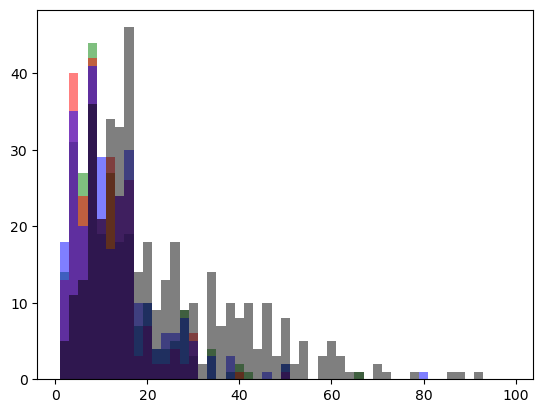

In [113]:
dfd = dfa[dfa['Drug'] == 'Baseline'] 
dfd = dfd[dfd['GlobalSpindle'] == 'Global'] 

dfd['SpikeActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dfd['CalciumActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dff = dfd.pivot_table(index='Unit_ID', columns=[dfd['SpikeActivityPreference']], values='SpikeActivityPreference', aggfunc='count', fill_value=0)
dff['Total']=dff.sum(axis=1)

dff['%Before']=np.round(dff['Before']/dff['Total']*100,2)
dff['%During']=np.round(dff['During']/dff['Total']*100,2)
dff['%After']=np.round(dff['After']/dff['Total']*100,2)
dff['%Response']=np.round((dff['Before']+dff['During']+dff['After'])/dff['Total']*100,2)

bin_edges = range(1,100,2)
plt.close()
plt.hist(dff['%Before'], bins=bin_edges,  alpha=0.5, color='green')
plt.hist(dff['%During'], bins=bin_edges,  alpha=0.5, color='red')
plt.hist(dff['%After'], bins=bin_edges,  alpha=0.5, color='blue')
plt.hist(dff['%Response'], bins=bin_edges,  alpha=0.5, color='black')
print('% Before=',round(np.mean(dff['%Before']),2))
print('% During=',round(np.mean(dff['%During']),2))
print('% After=',round(np.mean(dff['%After']),2))
print('% Response=',round(np.mean(dff['%Response']),2))

plt.show()


In [114]:
dff[dff['%During']>20]

SpikeActivityPreference,After,Before,During,NoPref,Total,%Before,%During,%After,%Response
Unit_ID,,,,,,,,,
Purple1047,0,3,3,0,6,50.00,50.00,0.00,100.00
Purple130,2,1,3,8,14,7.14,21.43,14.29,42.86
Purple52,2,3,7,16,28,10.71,25.00,7.14,42.86
ThreeColDotsOK112,4,1,9,9,23,4.35,39.13,17.39,60.87
ThreeColDotsOK128,5,3,7,19,34,8.82,20.59,14.71,44.12
ThreeColDotsOK1341,3,0,3,4,10,0.00,30.00,30.00,60.00
ThreeColDotsOK149,1,2,4,6,13,15.38,30.77,7.69,53.85
ThreeColDotsOK204,6,4,8,16,34,11.76,23.53,17.65,52.94
ThreeColDotsOK296,3,5,6,9,23,21.74,26.09,13.04,60.87


% Before= 4.8
% During= 4.28
% After= 5.42
% Response= 14.5


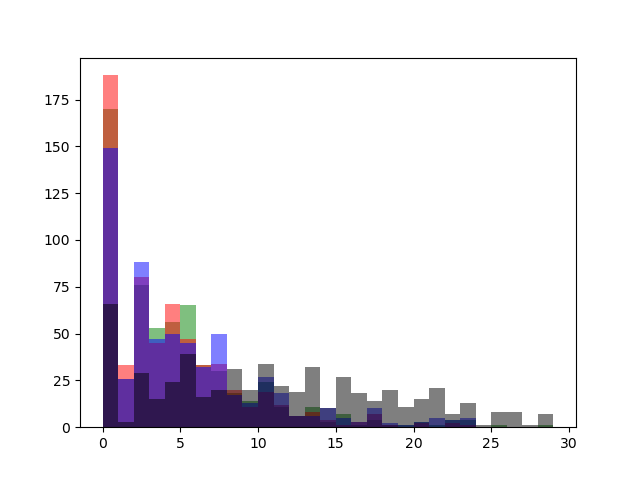

In [386]:
dfd = dfa[dfa['Drug'] == 'Baseline'] 
dfd = dfd[dfd['GlobalSpindle'] == 'Local'] 
dfd = dfd[dfd['SpdlStartLocation'] == 'S1'] 

dfd['SpikeActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dfd['CalciumActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dff = dfd.pivot_table(index='Unit_ID', columns=[dfd['SpikeActivityPreference']], values='SpikeActivityPreference', aggfunc='count', fill_value=0)
dff['Total']=dff.sum(axis=1)

dff['%Before']=np.round(dff['Before']/dff['Total']*100,2)
dff['%During']=np.round(dff['During']/dff['Total']*100,2)
dff['%After']=np.round(dff['After']/dff['Total']*100,2)
dff['%Response']=np.round((dff['Before']+dff['During']+dff['After'])/dff['Total']*100,2)

dff

bin_edges = range(0,30,1)
plt.close()
plt.hist(dff['%Before'], bins=bin_edges,  alpha=0.5, color='green')
plt.hist(dff['%During'], bins=bin_edges,  alpha=0.5, color='red')
plt.hist(dff['%After'], bins=bin_edges,  alpha=0.5, color='blue')
plt.hist(dff['%Response'], bins=bin_edges,  alpha=0.5, color='black')

print('% Before=',round(np.mean(dff['%Before']),2))
print('% During=',round(np.mean(dff['%During']),2))
print('% After=',round(np.mean(dff['%After']),2))
print('% Response=',round(np.mean(dff['%Response']),2))

plt.show()

In [387]:
dff[dff['%During']>20]

SpikeActivityPreference,After,Before,During,NoPref,Total,%Before,%During,%After,%Response
Unit_ID,,,,,,,,,
Purple196,0,0,1,2,3,0.00,33.33,0.00,33.33
Purple429,0,3,4,6,13,23.08,30.77,0.00,53.85
Purple628,0,0,1,2,3,0.00,33.33,0.00,33.33
Purple955,11,9,11,16,47,19.15,23.40,23.40,65.96
ThreeBlueCrossesOK23,2,2,2,3,9,22.22,22.22,22.22,66.67
ThreeColDotsOK820,6,7,6,8,27,25.93,22.22,22.22,70.37


% Before= 4.59
% During= 4.61
% After= 4.74
% Response= 13.94


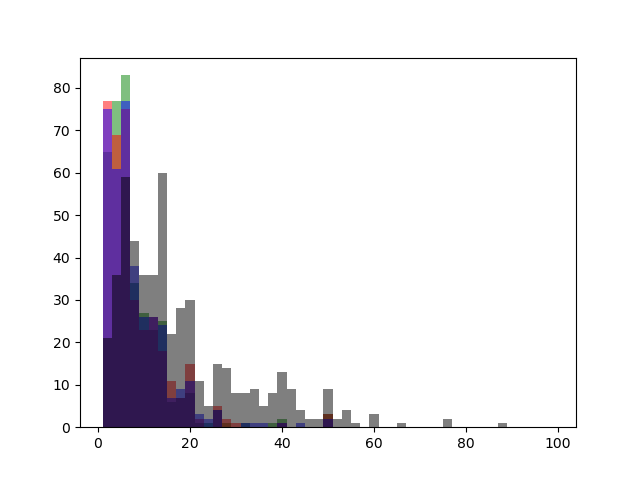

In [388]:
dfd = dfa[dfa['Drug'] == 'Baseline'] 
dfd = dfd[dfd['GlobalSpindle'] == 'Local'] 
dfd = dfd[dfd['SpdlStartLocation'] == 'PFC'] 

dfd['SpikeActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dfd['CalciumActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dff = dfd.pivot_table(index='Unit_ID', columns=[dfd['SpikeActivityPreference']], values='SpikeActivityPreference', aggfunc='count', fill_value=0)
dff['Total']=dff.sum(axis=1)

dff['%Before']=np.round(dff['Before']/dff['Total']*100,2)
dff['%During']=np.round(dff['During']/dff['Total']*100,2)
dff['%After']=np.round(dff['After']/dff['Total']*100,2)
dff['%Response']=np.round((dff['Before']+dff['During']+dff['After'])/dff['Total']*100,2)

dff

bin_edges = range(1,100,2)
plt.close()
plt.hist(dff['%Before'], bins=bin_edges,  alpha=0.5, color='green')
plt.hist(dff['%During'], bins=bin_edges,  alpha=0.5, color='red')
plt.hist(dff['%After'], bins=bin_edges,  alpha=0.5, color='blue')
plt.hist(dff['%Response'], bins=bin_edges,  alpha=0.5, color='black')

print('% Before=',round(np.mean(dff['%Before']),2))
print('% During=',round(np.mean(dff['%During']),2))
print('% After=',round(np.mean(dff['%After']),2))
print('% Response=',round(np.mean(dff['%Response']),2))
plt.show()

In [389]:
dff[dff['%During']>20]

SpikeActivityPreference,After,Before,During,NoPref,Total,%Before,%During,%After,%Response
Unit_ID,,,,,,,,,
Purple30,0,0,2,5,7,0.00,28.57,0.00,28.57
Purple447,0,0,2,3,5,0.00,40.00,0.00,40.00
Purple511,0,0,2,5,7,0.00,28.57,0.00,28.57
ThreeColDotsOK1319,1,4,5,10,20,20.00,25.00,5.00,50.00
ThreeColDotsOK1329,7,2,6,5,20,10.00,30.00,35.00,75.00
ThreeColDotsOK22,0,3,5,11,19,15.79,26.32,0.00,42.11
ThreeColDotsOK257,2,2,4,7,15,13.33,26.67,13.33,53.33
ThreeColDotsOK287,0,0,1,1,2,0.00,50.00,0.00,50.00
ThreeColDotsOK294,3,0,4,8,15,0.00,26.67,20.00,46.67
